<a href="https://colab.research.google.com/github/pchapr/colab_learning/blob/main/MultiVariateAnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 Using data/finanacial_data.csv would like to build a deep learning model to identify anomolies

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Embedding, Concatenate, Reshape
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_error, precision_recall_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import datetime


In [30]:
# Read the CSV file into a pandas DataFrame
financial_data_df = pd.read_csv('data/financial_data.csv')
financial_data_df = financial_data_df.sample(n=1000000, random_state=42).reset_index(drop=True)

In [32]:
# Display the first few rows of the DataFrame to understand its structure
#print(financial_data_df.head())

# Get basic information about the DataFrame (column types, non-null values)
#print(financial_data_df.info())

# Get descriptive statistics of the numerical columns
#print(financial_data_df.describe())
financial_data_df.iloc[0]
financial_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1000000 non-null  int64  
 1   type            1000000 non-null  object 
 2   amount          1000000 non-null  float64
 3   nameOrig        1000000 non-null  object 
 4   oldbalanceOrg   1000000 non-null  float64
 5   newbalanceOrig  1000000 non-null  float64
 6   nameDest        1000000 non-null  object 
 7   oldbalanceDest  1000000 non-null  float64
 8   newbalanceDest  1000000 non-null  float64
 9   isFraud         1000000 non-null  int64  
 10  isFlaggedFraud  1000000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 83.9+ MB


In [33]:
financial_data_df['nameDest'].unique().size

647823

In [34]:
numerical_features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
categorical_features = ['type']
origin_dest_features = ['nameOrig', 'nameDest']

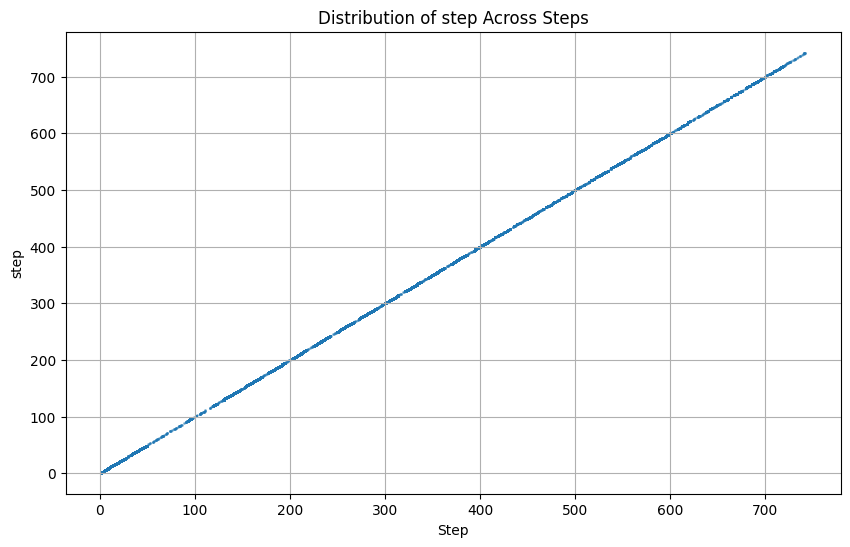

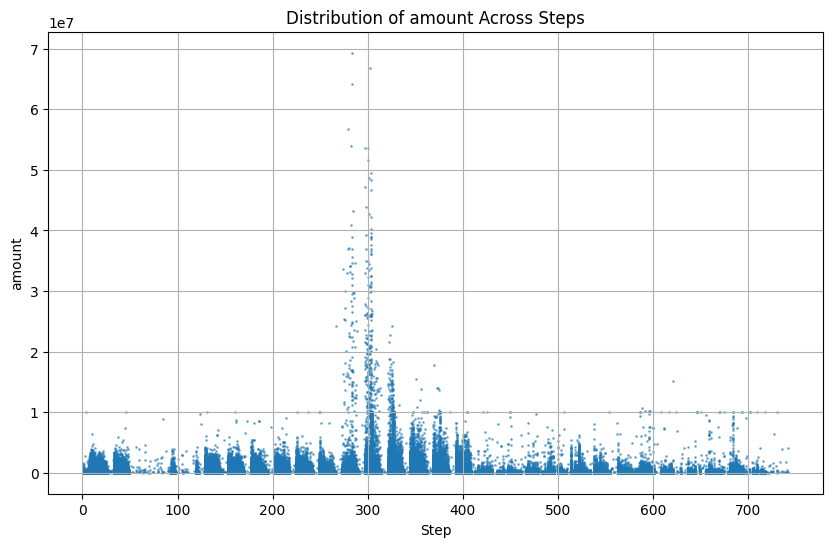

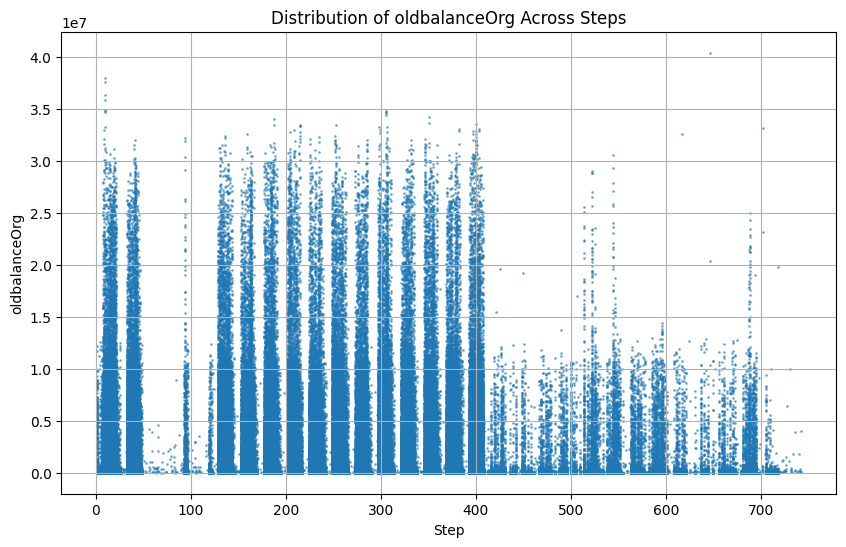

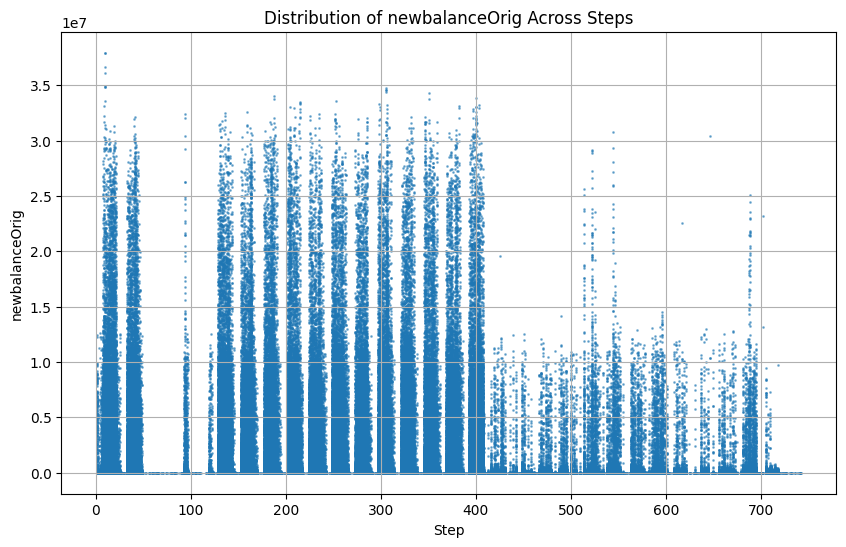

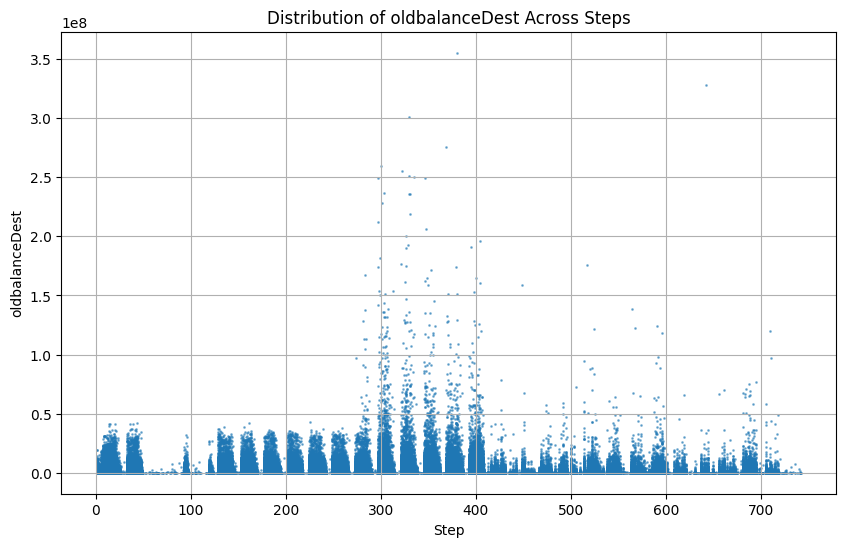

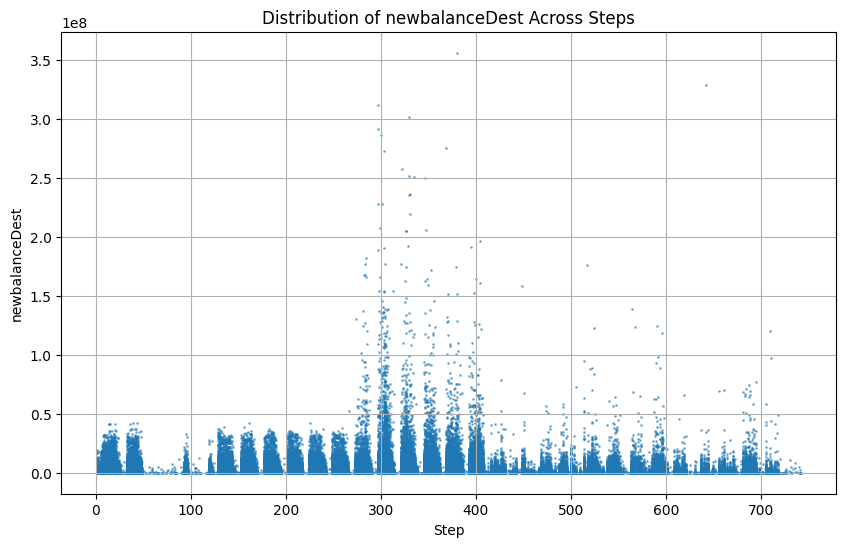

In [35]:
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    plt.scatter(financial_data_df['step'], financial_data_df[feature], alpha=0.5, s=1)
    plt.title(f'Distribution of {feature} Across Steps')
    plt.xlabel('Step')
    plt.ylabel(feature)
    plt.grid(True)
    plt.show()

In [36]:
# Scale numerical features
scaler = StandardScaler()
financial_data_df[numerical_features] = scaler.fit_transform(financial_data_df[numerical_features])

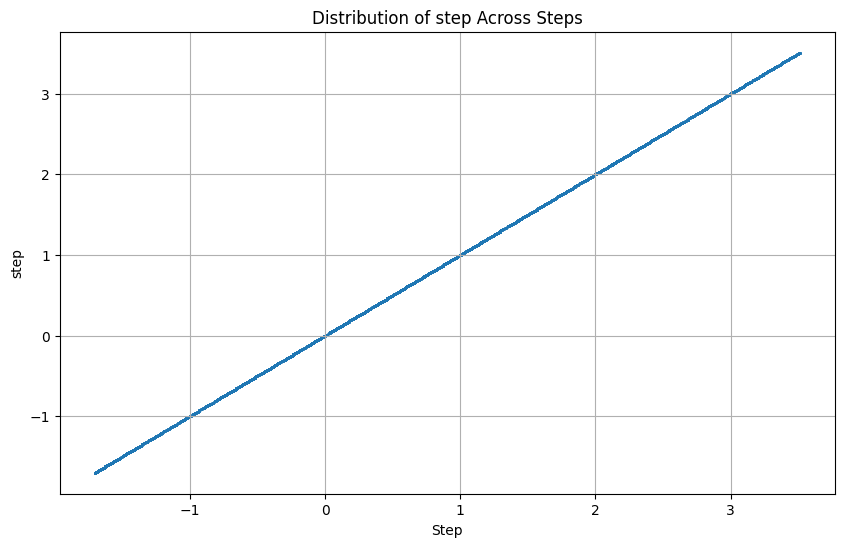

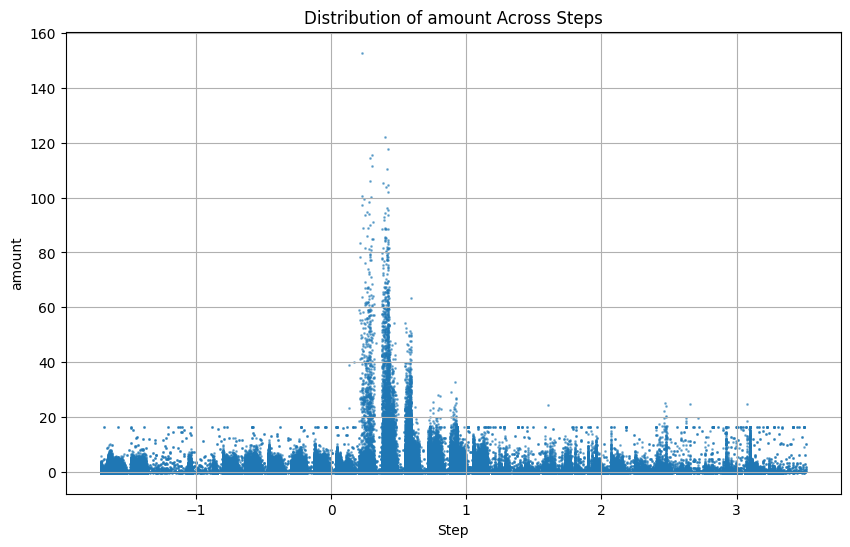

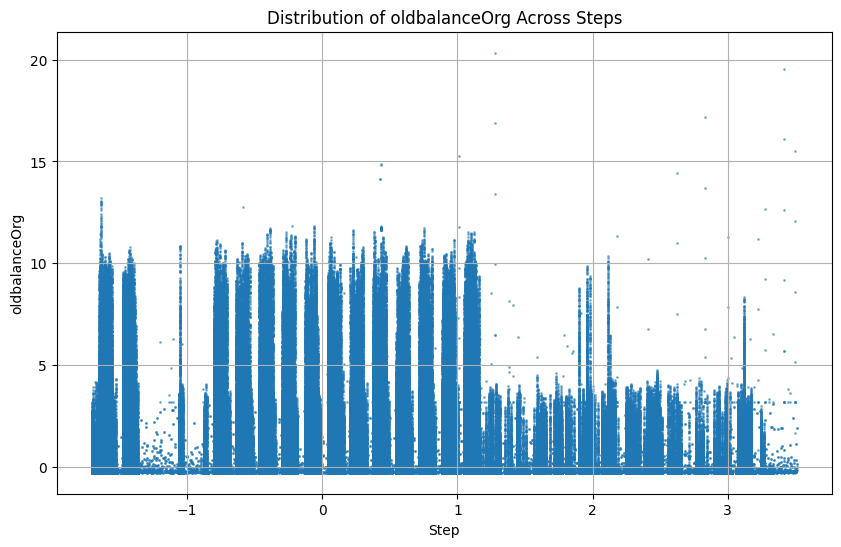

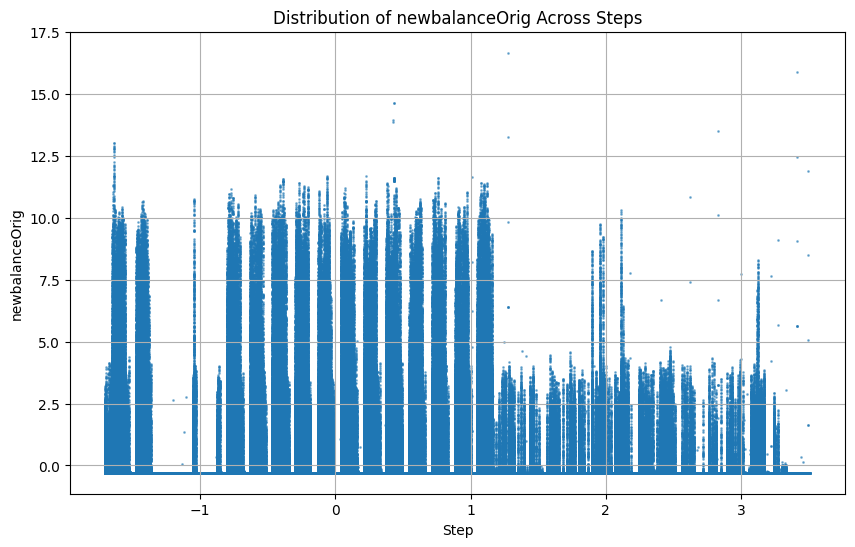

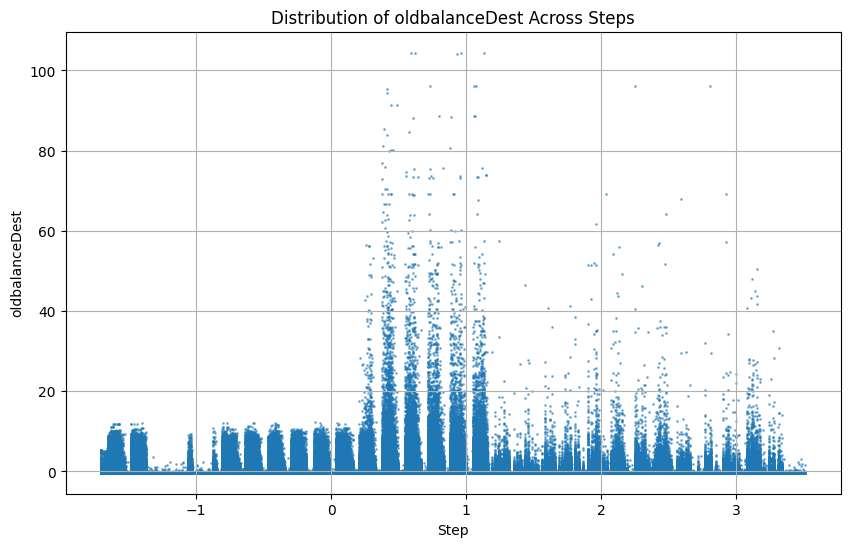

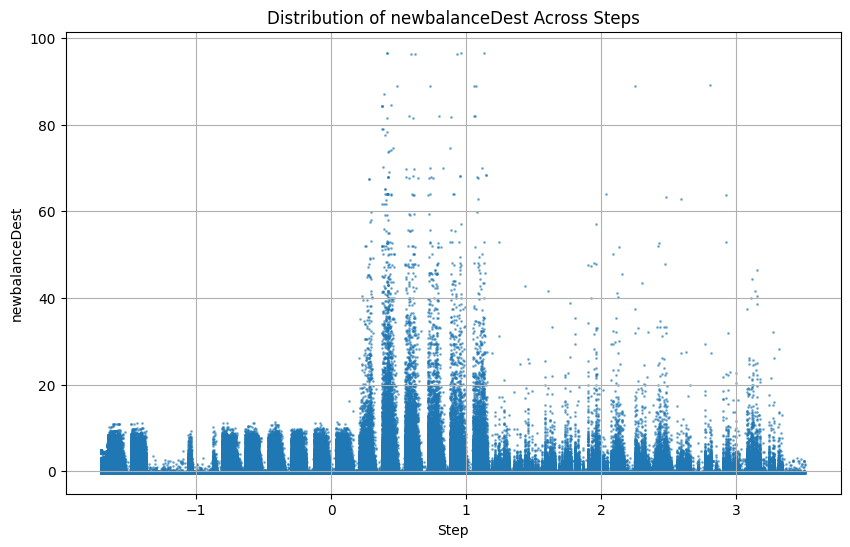

In [7]:
# prompt: Plot the numeric fields distribution across steps

# Plot distribution of numerical features across steps
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    plt.scatter(financial_data_df['step'], financial_data_df[feature], alpha=0.5, s=1)
    plt.title(f'Distribution of {feature} Across Steps')
    plt.xlabel('Step')
    plt.ylabel(feature)
    plt.grid(True)
    plt.show()


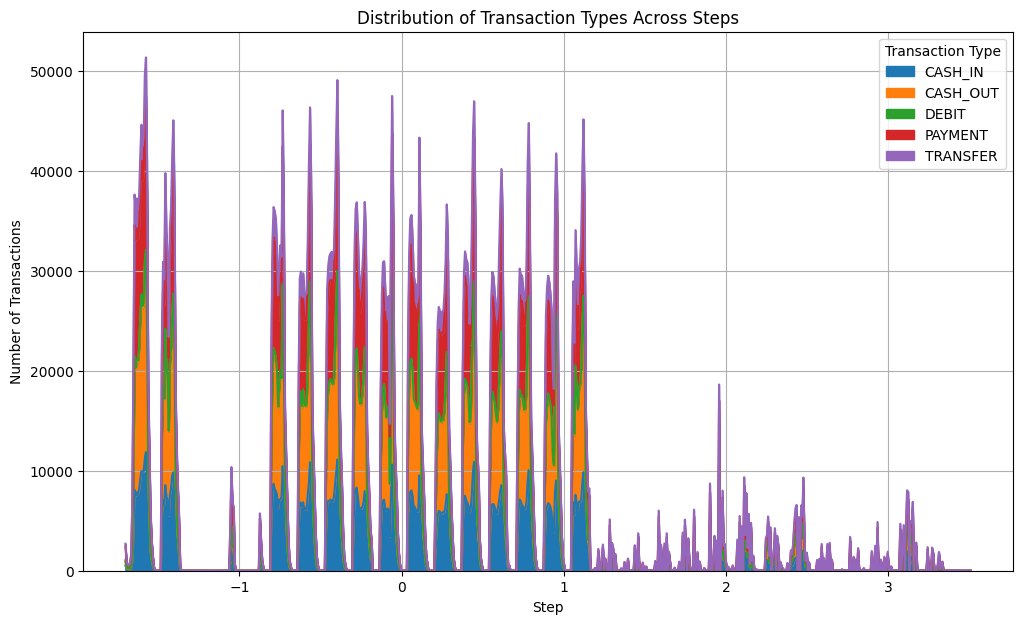

In [8]:
# prompt: Chart the type distribuction across steps as area

# Plot distribution of categorical features across steps
plt.figure(figsize=(12, 7))
financial_data_df.groupby('step')['type'].value_counts().unstack().plot(kind='area', stacked=True, ax=plt.gca())
plt.title('Distribution of Transaction Types Across Steps')
plt.xlabel('Step')
plt.ylabel('Number of Transactions')
plt.legend(title='Transaction Type')
plt.grid(True)
plt.show()

In [37]:
# One-hot encode 'type'
encoder = OneHotEncoder(sparse_output=False)
type_encoded = encoder.fit_transform(financial_data_df[['type']])
type_df = pd.DataFrame(type_encoded, columns=encoder.get_feature_names_out(['type']))
financial_data_df = pd.concat([financial_data_df.drop('type', axis=1).reset_index(drop=True), type_df], axis=1)

In [12]:
financial_data_df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,-1.703042,-0.281560,C1231006815,-0.229810,-0.237622,M1979787155,-0.323814,-0.333411,0,0,0.0,0.0,0.0,1.0,0.0
1,-1.703042,-0.294767,C1666544295,-0.281359,-0.285812,M2044282225,-0.323814,-0.333411,0,0,0.0,0.0,0.0,1.0,0.0
2,-1.703042,-0.297555,C1305486145,-0.288654,-0.292442,C553264065,-0.323814,-0.333411,1,0,0.0,0.0,0.0,0.0,1.0
3,-1.703042,-0.297555,C840083671,-0.288654,-0.292442,C38997010,-0.317582,-0.333411,1,0,0.0,1.0,0.0,0.0,0.0
4,-1.703042,-0.278532,C2048537720,-0.274329,-0.282221,M1230701703,-0.323814,-0.333411,0,0,0.0,0.0,0.0,1.0,0.0


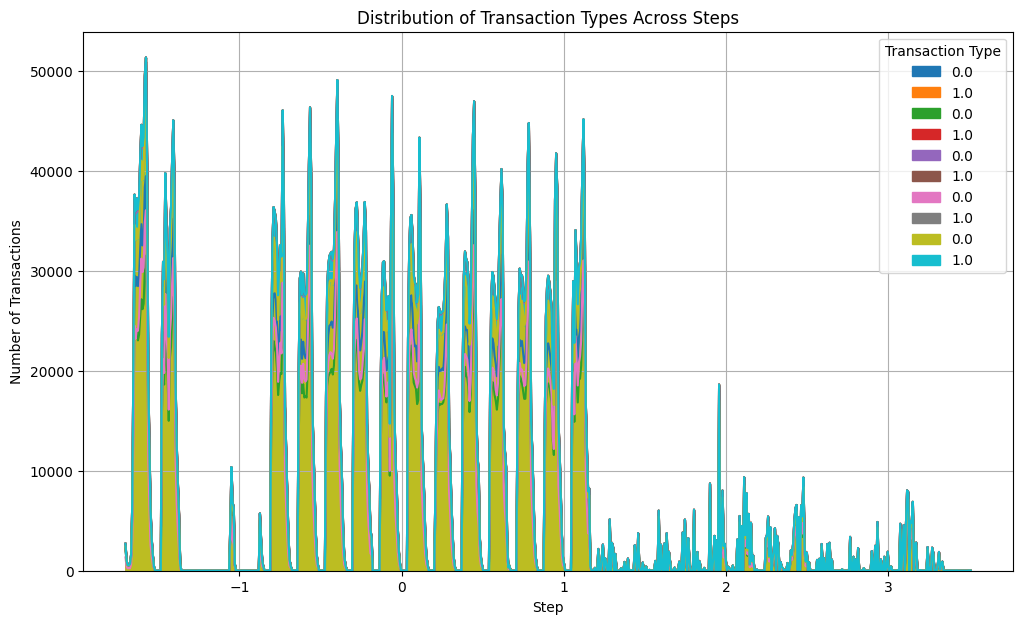

In [10]:
# prompt: Chart the type distribuction across steps as area

# Plot distribution of categorical features across steps
plt.figure(figsize=(12, 7))
financial_data_df.groupby('step')['type_CASH_IN'].value_counts().unstack().plot(kind='area', stacked=True, ax=plt.gca())
financial_data_df.groupby('step')['type_CASH_OUT'].value_counts().unstack().plot(kind='area', stacked=True, ax=plt.gca())
financial_data_df.groupby('step')['type_DEBIT'].value_counts().unstack().plot(kind='area', stacked=True, ax=plt.gca())
financial_data_df.groupby('step')['type_PAYMENT'].value_counts().unstack().plot(kind='area', stacked=True, ax=plt.gca())
financial_data_df.groupby('step')['type_TRANSFER'].value_counts().unstack().plot(kind='area', stacked=True, ax=plt.gca())
plt.title('Distribution of Transaction Types Across Steps')
plt.xlabel('Step')
plt.ylabel('Number of Transactions')
plt.legend(title='Transaction Type')
plt.grid(True)
plt.show()

In [38]:
# Tokenizing the text field for deeplearning model training
max_origin_features = financial_data_df['nameOrig'].nunique()
origin_tokenizer = Tokenizer(num_words=max_origin_features)
origin_tokenizer.fit_on_texts(financial_data_df['nameOrig'])
origin_sequences = origin_tokenizer.texts_to_sequences(financial_data_df['nameOrig'])
padded_origin = pad_sequences(origin_sequences, maxlen=1) # Still treat as sequence of length 1 at each step

In [15]:
financial_data_df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,-1.703042,-0.281560,C1231006815,-0.229810,-0.237622,M1979787155,-0.323814,-0.333411,0,0,0.0,0.0,0.0,1.0,0.0
1,-1.703042,-0.294767,C1666544295,-0.281359,-0.285812,M2044282225,-0.323814,-0.333411,0,0,0.0,0.0,0.0,1.0,0.0
2,-1.703042,-0.297555,C1305486145,-0.288654,-0.292442,C553264065,-0.323814,-0.333411,1,0,0.0,0.0,0.0,0.0,1.0
3,-1.703042,-0.297555,C840083671,-0.288654,-0.292442,C38997010,-0.317582,-0.333411,1,0,0.0,1.0,0.0,0.0,0.0
4,-1.703042,-0.278532,C2048537720,-0.274329,-0.282221,M1230701703,-0.323814,-0.333411,0,0,0.0,0.0,0.0,1.0,0.0


In [39]:
max_dest_features = financial_data_df['nameDest'].nunique()
dest_tokenizer = Tokenizer(num_words=max_dest_features)
dest_tokenizer.fit_on_texts(financial_data_df['nameDest'])
dest_sequences = dest_tokenizer.texts_to_sequences(financial_data_df['nameDest'])
padded_dest = pad_sequences(dest_sequences, maxlen=1) # Still treat as sequence of length 1 at each step

In [40]:
# Combine features for sequence generation
feature_columns = numerical_features + list(type_df.columns)
X = financial_data_df[feature_columns].values
origin_ids = padded_origin.reshape(-1, 1)
dest_ids = padded_dest.reshape(-1, 1)
y_fraud = financial_data_df['isFraud'].values

# 3. Sequence Generation
sequence_length = 10 # Choose an appropriate sequence length
batch_size = 128

In [41]:
# Combine features for sequence generation (now including tokenized IDs)
def create_sequences_with_ids(data_numerical_encoded, data_type_encoded, origin_ids, dest_ids, y, sequence_length):
    # ... (Logic to create sequences where each step includes numerical, type, origin_id, dest_id) ...
    sequences = []
    targets = []
    y_seqs = []
    for i in range(len(data_numerical_encoded) - sequence_length):
        numerical_seq = data_numerical_encoded[i:i + sequence_length]
        type_seq = data_type_encoded[i:i + sequence_length]
        origin_seq = origin_ids[i:i + sequence_length]
        dest_seq = dest_ids[i:i + sequence_length]
        combined_seq = np.concatenate([numerical_seq, type_seq, origin_seq, dest_seq], axis=1) # Combine features
        target = data_numerical_encoded[i + sequence_length]
        y_val = y[i:i + sequence_length]
        sequences.append(combined_seq)
        targets.append(target)
        y_seqs.append(y_val)
    return np.array(sequences), np.array(targets), np.array(y_seqs)

In [42]:
numerical_encoded = scaler.transform(financial_data_df[numerical_features]) # Ensure scaling is done before sequence creation

In [43]:
X_seq, y_next, y_fraud_seq = create_sequences_with_ids(
    numerical_encoded, type_encoded, padded_origin, padded_dest, y_fraud, sequence_length
)

In [45]:
print("X_seq.shape:", X_seq.shape)
print("y_next.shape:", y_next.shape)
print("y_fraud_seq.shape:", y_fraud_seq.shape)

X_seq.shape: (999990, 10, 13)
y_next.shape: (999990, 6)
y_fraud_seq.shape: (999990, 10)


In [46]:
# Split data into training and testing sets
# First, get the sequence indices for origin and dest that match X_seq length
origin_seq = origin_sequences[sequence_length:]
dest_seq = dest_sequences[sequence_length:]

# Now split the data with matching lengths
X_train, X_test, y_train_fraud, y_test_fraud, origin_train, origin_test, dest_train, dest_test = train_test_split(
    X_seq,
    y_fraud_seq,
    origin_seq,
    dest_seq,
    test_size=0.2,
    random_state=42,
    shuffle=False
)

In [47]:
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("y_train_fraud.shape:", y_train_fraud.shape)
print("y_test_fraud.shape:", y_test_fraud.shape)


X_train.shape: (799992, 10, 13)
X_test.shape: (199998, 10, 13)
y_train_fraud.shape: (799992, 10)
y_test_fraud.shape: (199998, 10)


In [48]:
embedding_dim=50 
n_numerical_features = len(numerical_features)
n_type_features = type_encoded.shape[1]

input_numerical = Input(shape=(sequence_length, n_numerical_features), name='numerical_input')
input_type = Input(shape=(sequence_length, n_type_features), name='type_input')
input_origin = Input(shape=(sequence_length, 1), name='origin_input')
input_dest = Input(shape=(sequence_length, 1), name='dest_input')

embedding_origin = Embedding(input_dim=max_origin_features, output_dim=embedding_dim, input_length=sequence_length)(input_origin)
embedding_dest = Embedding(input_dim=max_dest_features, output_dim=embedding_dim, input_length=sequence_length)(input_dest)

# Reshape the embedding outputs to remove the extra dimension
reshape_origin = Reshape((sequence_length, embedding_dim))(embedding_origin)
reshape_dest = Reshape((sequence_length, embedding_dim))(embedding_dest)

merged_input = Concatenate(axis=-1)([input_numerical, input_type, reshape_origin, reshape_dest])


c:\Projects\DeepLearning\colab_learning\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [49]:
# Encoder
lstm_enc_1 = LSTM(128, activation='relu', return_sequences=True)(merged_input)
lstm_enc_2 = LSTM(64, activation='relu', return_sequences=False)(lstm_enc_1)
repeat_vector = RepeatVector(sequence_length)(lstm_enc_2)

# Decoder
lstm_dec_1 = LSTM(64, activation='relu', return_sequences=True)(repeat_vector)
lstm_dec_2 = LSTM(128, activation='relu', return_sequences=True)(lstm_dec_1)
output_numerical = TimeDistributed(Dense(n_numerical_features))(lstm_dec_2)
output_type = TimeDistributed(Dense(n_type_features, activation='sigmoid'))(lstm_dec_2) # Assuming one-hot encoded

autoencoder = Model(inputs=[input_numerical, input_type, input_origin, input_dest], outputs=[output_numerical, output_type])
autoencoder.compile(optimizer='adam', loss=['mse', 'categorical_crossentropy']) # Adjust loss if needed

print(autoencoder.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ origin_input        │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dest_input          │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 10, 1, 50) │ 49,988,450 │ origin_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 10, 1, 50) │ 32,391,150 │ dest_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 10, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ type_input          │ (None, 10, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 10, 50)    │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 10, 50)    │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 10, 111)   │          0 │ numerical_input[… │
│ (Concatenate)       │                   │            │ type_input[0][0], │
│                     │                   │            │ reshape_2[0][0],  │
│                     │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 10, 128)   │    122,880 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 64)        │     49,408 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 10, 64)    │          0 │ lstm_5[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 10, 64)    │     33,024 │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 10, 128)   │     98,816 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 10, 6)     │        774 │ lstm_7[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 10, 5)     │        645 │ lstm_7[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 82,685,147 (315.42 MB)

 Trainable params: 82,685,147 (315.42 MB)

 Non-trainable params: 0 (0.00 B)

None


In [50]:
# 5. TensorBoard Callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [51]:
# 6. Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [52]:
#transorboard to visualize the model architecture
#Visualize the model layers
from tensorflow.keras.utils import plot_model

plot_model(autoencoder, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [ ]:
# 7. Train the Model with Callbacks
epochs = 5
batch_size = 8
history = autoencoder.fit(
    X_train, X_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    shuffle=False,
    callbacks=[tensorboard_callback, early_stopping_callback],
    verbose=1
)

Epoch 1/5


ValueError: Layer "functional_1" expects 4 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(None, 10, 13) dtype=float32>]

In [ ]:
# 8. Anomaly Detection
X_train_pred = autoencoder.predict(X_train)
train_mse = np.mean(np.square(X_train - X_train_pred), axis=(1, 2))

X_test_pred = autoencoder.predict(X_test)
test_mse = np.mean(np.square(X_test - X_test_pred), axis=(1, 2))

threshold = np.percentile(train_mse, 95)
anomalies = test_mse > threshold

# 9. Evaluate Performance
def plot_precision_recall(y_true, anomaly_scores):
    precision, recall, thresholds = precision_recall_curve(y_true, anomaly_scores)
    auc_score = auc(recall, precision)
    plt.plot(recall, precision, label=f'AUC = {auc_score:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    return auc_score

test_fraud_labels_aligned = y_test_fraud_seq[:, -1]
plot_precision_recall(test_fraud_labels_aligned, test_mse)

y_pred = (test_mse > threshold).astype(int)
print("\nClassification Report (based on threshold):")
print(classification_report(test_fraud_labels_aligned, y_pred))